In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
from nilearn.mass_univariate import permuted_ols

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [9]:
mpl.rcParams['font.family'] = 'Helvetica'

## Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [10]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)

In [11]:
list_sn = su.get_list_sn()

---

In [12]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [13]:
list_roi = simage.get_list_roi()

In [14]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

In [15]:
dir_group = join(dir_surf,'group')

---
---

In [16]:
subj = 'S01'

In [17]:
reginfo = deal_spm.load_reginfo(subj,dir_glm)
reginfo

,sn,run,name,ons
0,1,1,"(2,S)",6.03
1,1,1,"(4,S)",11.03
2,1,1,"(4,L)",16.03
3,1,1,"(2,L)",21.03
4,1,1,"(1,S)",26.03
...,...,...,...,...
539,1,8,"(3,S)",3215.03
540,1,8,"(3,L)",3220.03
541,1,8,"(2,S)",3225.03
542,1,8,"(2,L)",3230.03


In [18]:
def get_df_idx(subj, glm):
    reginfo = deal_spm.load_reginfo(subj,dir_glm)
    df_idx = pd.DataFrame()
    df_idx['letter'] = reginfo.name.str.contains('L', case=False).values
    df_idx['spatial'] = reginfo.name.str.contains('S', case=False).values
    for seq in np.arange(1,5):
        df_idx['seq%d'%seq] = reginfo.name.str.contains('%d'%seq, case=False).values

    ## cue repetition
    idx_ = {}
    for cue in ['letter','spatial']:
        tmp = df_idx[cue].values
        idx_rep = tmp == np.roll(tmp, 1)
        ## each first trial would be False
        for trial in np.arange(stop=544,step=17):
            idx_rep[trial] = False
        idx_[cue] = idx_rep
    assert (idx_['letter']==idx_['spatial']).all
    df_idx['cue-rep'] = idx_rep
    del idx_
    
    ## seq repetition
    idx_ = np.zeros(544)
    for ss in np.arange(4):
        seq = 'seq%d'%(ss+1)
        tmp = df_idx[seq].values
        idx_rep = (tmp==True)&(np.roll(tmp, 1)==True)
        ## each first trial of blocks would be False
        for trial in np.arange(stop=544,step=17):
            idx_rep[trial] = False
        idx_ += idx_rep.astype(int)
    assert not (idx_>1).any()
    df_idx['seq-rep'] = idx_.astype(bool)
    
    return df_idx

In [19]:
df_idx = get_df_idx(subj=subj, glm=glm)
df_idx

,letter,spatial,seq1,seq2,seq3,seq4,cue-rep,seq-rep
0,False,True,False,True,False,False,False,False
1,False,True,False,False,False,True,True,False
2,True,False,False,False,False,True,False,True
3,True,False,False,True,False,False,True,False
4,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
539,False,True,False,False,True,False,True,False
540,True,False,False,False,True,False,False,True
541,False,True,False,True,False,False,False,False
542,True,False,False,True,False,False,False,True


---
---

### i) Calculate Contrast

In [20]:
# # betas: (X, Y, Z, trials)
# # condA_idx, condB_idx: list[int]  (0-based)
# def contrast_tmap_trialwise(betas, condA_idx, condB_idx):
#     A = betas[:, :, :, condA_idx]  # (X, Y, Z, nA)
#     B = betas[:, :, :, condB_idx]  # (X, Y, Z, nB)

#     mA = np.nanmean(A, axis=3)
#     mB = np.nanmean(B, axis=3)
#     sA = np.nanstd(A, axis=3, ddof=1)
#     sB = np.nanstd(B, axis=3, ddof=1)
#     nA = A.shape[3]
#     nB = B.shape[3]

#     se = np.sqrt((sA**2)/nA + (sB**2)/nB)
#     tmap = (mA - mB) / se

#     # Welch-Satterthwaite df (optional for p-values)
#     df = (se**4) / (((sA**2)/nA)**2/(nA-1) + ((sB**2)/nB)**2/(nB-1))

#     # p-values (two-tailed)
#     pmap = 2 * (1 - t.cdf(np.abs(tmap), df))
#     return tmap, pmap, df


In [21]:
def get_sig_mask(data=None, tested_vars=None, alpha=0.05):
    ## Find and remove voxels that are entirely zero
    mask_nonzero = ~np.all(data==0, axis=0)
    data = data[:, mask_nonzero]

    ## contrast (letter:1 vs. spatial:0)
    # tested_vars = df_idx.letter.astype(int).values

    assert data.shape[0]==tested_vars.shape[0]
    
    # permutation test
    res = permuted_ols(
        tested_vars=tested_vars,
        target_vars=data,
        n_perm=1000,
        two_sided_test=True,
        n_jobs=1,
        output_type="dict"
    )

    ## p value
    pvals = np.ones(32492) * np.nan
    pvals[mask_nonzero] = (10 ** -res['logp_max_t'].reshape(-1))

    ## define the signifivant voxel mask (FWER ≤ 0.05)
    sig_mask = (pvals <= alpha)

    ## t-map
    tmap = np.ones(32492) * np.nan
    tmap[mask_nonzero] = res['t'].reshape(-1)

    # ## meaningful t-map
    # significant_map = np.zeros_like(pvals)
    # significant_map[sig_mask] = tmap[sig_mask]

    return sig_mask, tmap

In [27]:
tolerance = 1.e-10

In [29]:
dataset = {}
for ii, nn in enumerate(tqdm(list_sn)):
    subj = 'S'+nn

    ## ============ beta =========== ##
    ## index
    df_idx = get_df_idx(subj=subj, glm=glm)

    ## load beta
    fname = join(dir_surf,'glm_%1d'%glm,subj,'%s.%s.glm_%d.beta.func.gii'%(subj,hem,glm))
    darrays = nb.load(fname).darrays
    data = np.ones((len(df_idx),32492)) * np.nan
    for jj, darray in enumerate(darrays):
        data[jj] = darray.data
    ## ============================= ##
    # contrast
    ## 1. beta difference
    sss='beta_mean'
    for cue in ['letter','spatial']:
        if ii==0:
            dataset[cue] = np.ones((len(list_sn),32492)) * np.nan
            # dataset['B_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            # dataset['S_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            # dataset['C_'+cue] = np.ones((len(list_sn),32492)) * np.nan
            # dataset['N_'+cue] = np.ones((len(list_sn),32492)) * np.nan
        idx_cue = df_idx[cue].values.astype(int)
        # idx_B = (df_idx['cue-rep']&df_idx['seq-rep']).values.astype(int)
        # idx_S = (~df_idx['cue-rep']&df_idx['seq-rep']).values.astype(int)
        # idx_C = (df_idx['cue-rep']&~df_idx['seq-rep']).values.astype(int)
        # idx_N = (~df_idx['cue-rep']&~df_idx['seq-rep']).values.astype(int)
        ## cue
        contrast = np.copy(idx_cue/idx_cue.sum()).astype(float)
        assert abs(contrast[contrast>0].sum()-1)<tolerance
        dataset[cue][ii,:] = contrast@data
        # ## Both-Rep
        # contrast = idx_B - np.roll(idx_B, -1)
        # dataset['B_'+cue][ii,:] = contrast@data
        # ## Seq-Rep
        # contrast = idx_S - np.roll(idx_S, -1)
        # dataset['S_'+cue][ii,:] = contrast@data
        # ## Cue-Rep
        # contrast = idx_C - np.roll(idx_C, -1)
        # dataset['C_'+cue][ii,:] = contrast@data
        # ## None-Rep
        # contrast = idx_N - np.roll(idx_N, -1)
        # dataset['N_'+cue][ii,:] = contrast@data

    # ## 2. t-map
    # sss='t_stat'
    # cond_vec = ['letter' if 'L' in cond else ('spatial' if 'S' in cond else 'invalid') for cond in reginfo.name]
    # t_stat = sstat.compute_t_stat(betas=data, conditions=cond_vec)
    # for jj, cue in enumerate(['letter','spatial']):
    #     if ii==0:
    #         dataset[cue] = np.ones((len(list_sn),32492)) * np.nan
    #     dataset[cue][ii,:] = t_stat[jj]
    ## ============================= ##

100%|███████████████████████████████████████████████████| 12/12 [04:44<00:00, 23.68s/it]


### Save the dataset as cifti

In [30]:
dir_output = join(dir_surf,'glm_%1d'%glm)
for key, value in dataset.items():
    simage.save_surf2cifti(
        data=value,
        dir_output=dir_output,
        label_axis=['S'+sn for sn in list_sn],
        prefix='cifti.%s.glm_%1d.%s.%s'%(hem,glm,sss,key)
    )

---
---

### ii) Load the dataset from cifti

In [31]:
sss = 'beta_mean'
dataset = {}
for cond in ['letter','spatial']:
    fname = join(dir_surf,'glm_%1d'%glm, 'smooth.cifti.%s.glm_%1d.%s.%s.dscalar.nii'%(hem,glm,sss,cond))
    dataset[cond] = nb.load(fname).get_fdata()

### t-test

In [32]:
for key, value in dataset.items():
    data = np.ones((2,32492)) * np.nan
    ## coeffcient
    data[0] = np.mean(value, axis=0)
    ## t-stat
    res = scipy.stats.ttest_1samp(value, popmean=0, axis=0)
    thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=res.df.mean())
    data[1] = res.statistic
    ## save the result as cifti
    simage.save_surf2cifti(
        data=data,
        dir_output=dir_group,
        label_axis=['coef','tstat'],
        prefix='smooth.cifti.%s.glm_%1d.t_stat.%s'%(hem,glm,key)
    )

---

## 1. Letter vs. Spatial

In [45]:
thresh = sstat.convert_alpha_to_tval(alpha=0.01, df=len(list_sn))
thresh

np.float64(3.0545395893929017)

In [78]:
def norm_cmap(cmap=cm.jet, vmax=10, thresh=thresh):
    gray = [0.5,0.5,0.5,1.0]
    ## 색상 샘플링
    colors = cmap(np.linspace(0, 1, 256))
    ## value range: -vmax, ..., -thresh, ..., 0, ..., thresh, ..., vmax
    ratio = thresh/vmax
    idx_gray = np.linspace(0, 2, 256)-1
    idx_gray = abs(idx_gray)<ratio
    assert len(colors)==len(idx_gray)
    colors[idx_gray] = gray
    cmap = mcolors.ListedColormap(colors)
    
    return cmap

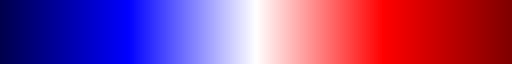

In [82]:
# cmap = norm_cmap(vmax=10, thresh=thresh)
cmap = cm.seismic
cmap

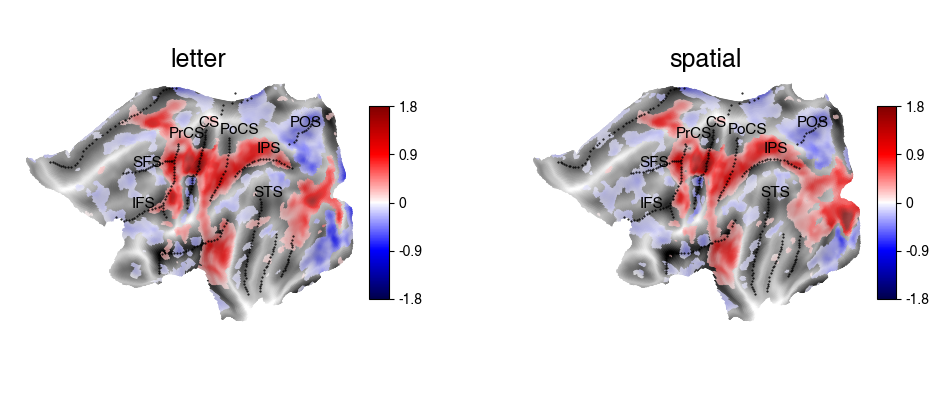

In [83]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=len(list_sn)-1)
for ii, sss in enumerate(['letter','spatial']):
    ax=axs[ii]
    plt.sca(ax)
            
    ## i) simple t-test
    fname = join(dir_group,'smooth.cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,sss))
    data = np.array(nb.load(fname).get_fdata())
    psc = np.copy(data[0])
    tmap = np.copy(data[1])

    idx = np.copy(abs(tmap)>thresh)
    psc[~idx] = np.nan
    
    ## ii) one-sample permutation test
    # fname = join(dir_surf,'glm_%1d'%glm, 'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,sss))
    # data = np.array(nb.load(fname).get_fdata())
    # # one-sample test: constant predictor
    # tested_vars = np.ones((12, 1))
    # # permutation test
    # res = permuted_ols(
    #     tested_vars=tested_vars,
    #     target_vars=data,
    #     n_perm=10000,
    #     two_sided_test=True,
    #     n_jobs=1,
    #     output_type="dict"
    # )
    # tmap = res['t'].reshape(-1)
    
    color = 'black'
    g = surf.plot.plotmap(
        data=psc,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-1.8,1.8],
        # threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=1,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=sss, ha='center', va='center', fontsize=18)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=11)

## 2. Zoom-in

In [78]:
# vmin, vmax = -10, 10

In [54]:
# fig, axs = plt.subplots(ncols=2, figsize=(12,5))

# for ii, sss in enumerate(['letter','spatial']):
#     ax = axs[ii]
#     plt.sca(ax)
    
#     result = scipy.stats.ttest_1samp(dataset[sss], popmean=0, axis=0)
#     thresh = sstat.convert_alpha_to_tval(alpha=0.01, df=result.df.mean())

#     data = np.copy(result.statistic)
#     # data = scipy.ndimage.gaussian_filter(data, sigma=0.75)
#     data[np.abs(result.statistic)<thresh] = np.nan
#     if sss=='letter':
#         cmap = cm.seismic
#     else:
#         cmap = cm.seismic_r
#     color = 'white'
#     g = surf.plot.plotmap(
#         data=data,
#         surf='fs32k_L',
#         alpha=0.7,
#         cmap=cmap, colorbar=True,
#         cscale=[vmin,vmax],
#         borders=border, bordercolor=color, bordersize=1,
#         overlay_type='func', render='matplotlib'
#     )
#     g.text(x=20, y=220, s=sss, ha='center', va='center', fontsize=14)
#     for line, (x, y) in brdr.items():
#         g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)
        
#     rect = patches.Rectangle(
#         xy=(-40, -40), width=260, height=170,
#         linewidth=2, edgecolor='k', facecolor='none', linestyle='--'
#     )
#     g.add_patch(rect)
#     # xmin = rect.get_x()
#     # xmax = xmin + rect.get_width()
#     # ymin = rect.get_y()
#     # ymax = ymin + rect.get_height()
#     # g.set_xlim(xmin,xmax)
#     # g.set_ylim(ymin,ymax)

## 3. Overlap t-map

In [85]:
dataset = []
threshold = np.ones(3)

for ii, sss in enumerate(['letter',None,'spatial']):
    if sss==None:
        dataset.append(None)
        continue
    ## set alpha
    thresh = sstat.convert_alpha_to_tval(alpha=0.01, df=len(list_sn)-1)
    threshold[ii] = thresh

    ## set rgb
    fname = join(dir_group,'smooth.cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,sss))
    data = np.array(nb.load(fname).get_fdata())
    dataset.append(data[1])

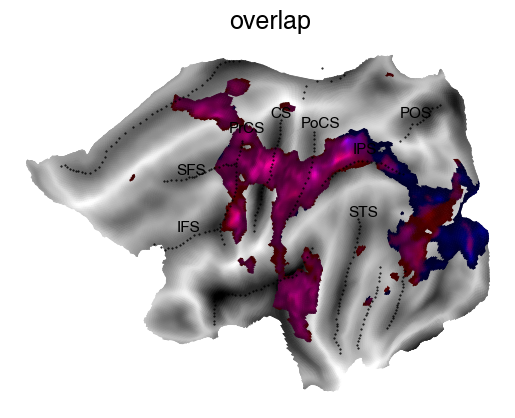

In [86]:
color = 'black'
g = surf.plot.plotmap(
    data=suit.flatmap.map_to_rgb(data=dataset, threshold=threshold),
    surf='fs32k_%s'%hem,
    colorbar=True,
    borders=border, bordercolor=color, bordersize=1,
    overlay_type='rgb',
)
g.text(x=20, y=220, s='overlap', ha='center', va='center', fontsize=18)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=11)

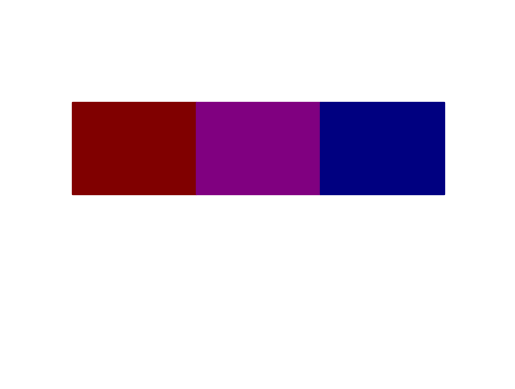

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# 전체 직사각형 크기
x, y, width, height = 0, 0, 3, 0.25

# 왼쪽 1/3 (Red: (255,0,0))
ax.add_patch(plt.Rectangle((x, y), width/3, height, 
                           color=(0.5, 0, 0)))

# 가운데 1/3 (Purple: (255,0,255))
ax.add_patch(plt.Rectangle((x+width/3, y), width/3, height, 
                           color=(0.5, 0, 0.5)))

# 오른쪽 1/3 (Blue: (0,0,255))
ax.add_patch(plt.Rectangle((x+2*width/3, y), width/3, height, 
                           color=(0, 0, 0.5)))

ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-0.5, 0.5)
plt.axis('off')  # 테두리 제거
plt.show()

---